# House Building 3

## より複雑な問題

* 5件の家を、JoeとJimの2人で建てる  
* 工程ごとに担当者が決まっている
* 家ごとにReleaseDate以降に着手する必要がある
* 家ごとにDueDateが決まっている。遅れてもいいが、Weightで規定されるコストが余分にかかる
* 評価関数は「遅延によるコスト」+「家ごとの建築期間」でこれを最小化する

元リンク

https://ibmdecisionoptimization.github.io/tutorials/html/Scheduling_Tutorial.html

API reference

https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.expression.py.html

In [1]:
# 工程名
TaskNames = ["masonry", "carpentry", "plumbing", 
             "ceiling", "roofing", "painting", 
             "windows", "facade", "garden", "moving"]

# 工程毎の期間
Duration =  [35, 15, 40, 15, 5, 10, 5, 10, 5, 5]

# 工程間依存関係
Precedences = [("masonry", "carpentry"),("masonry", "plumbing"),
               ("masonry", "ceiling"), ("carpentry", "roofing"),
               ("ceiling", "painting"), ("roofing", "windows"),  
               ("roofing", "facade"), ("plumbing", "facade"),
               ("roofing", "garden"), ("plumbing", "garden"),
               ("windows", "moving"), ("facade", "moving"),  
               ("garden", "moving"), ("painting", "moving")]

# 家の件数
NbHouses = 5

# 作業者
WorkerNames = ["Joe", "Jim"]

# 工程毎の作業者分担
Worker = {"masonry"  : "Joe" , 
          "carpentry": "Joe" , 
          "plumbing" : "Jim" , 
          "ceiling"  : "Jim" , 
          "roofing"  : "Joe" , 
          "painting" : "Jim" , 
          "windows"  : "Jim" , 
          "facade"   : "Joe" , 
          "garden"   : "Joe" , 
          "moving"   : "Jim"}

# 着手日 (必ず守る必要あり)
ReleaseDate = [  0,     0,   151,    59,   243]

# 終了日 (遅れていいがコストが発生)
DueDate     = [120,   212,   304,   181,   425]

# 遅延コスト
Weight      = [100.0, 100.0, 100.0, 200.0, 100.0]

# 家IDのリスト([0, 1, 2, 3, 4])を生成
Houses = range(NbHouses)

In [2]:
# ライブラリのインポートとモデルインスタンスの生成

import sys
from docplex.cp.model import *
mdl2 = CpoModel()

In [3]:
# housesは家毎のInterval変数の配列
# 開始日はReleaseDateにより個別に指定

houses = [mdl2.interval_var(start=(ReleaseDate[i], INTERVAL_MAX), name="house"+str(i)) for i in Houses]

In [4]:
# <house_id>_<タスク名>でタスクごとのラベルを振る
# TaskNames_ids: タスク毎のラベルからタスクIDを取得する辞書
# itvs: (house_id, task_id)から該当するInterval変数を取得する辞書
# タスク毎の期間(size)はDurationで決められている値を初期設定する

TaskNames_ids = {}
itvs = {}
for h in Houses:
    for i,t in enumerate(TaskNames):
        _name = str(h)+"_"+str(t)
        itvs[(h,t)] = mdl2.interval_var(size=Duration[i], name=_name)
        TaskNames_ids[_name] = i

In [5]:
# itvsの辞書の内容確認

print(itvs[(3, 'masonry')])

"3_masonry" = intervalVar(size=35)


In [6]:
# タスク間の依存関係定義

for h in Houses:
    for p in Precedences:
        mdl2.add(mdl2.end_before_start(itvs[(h,p[0])], itvs[(h,p[1])]) )

In [7]:
# span制約の設定

# 家のInterval変数は、個別タスクの集計で定まる。その関係をspan関数で設定
for h in Houses:
    mdl2.add( mdl2.span(houses[h], [itvs[(h,t)] for t in TaskNames] ) )

In [8]:
# workersの定義

# 作業者(Joe, Jim)ごとのタスクシーケンス変数として定義
# シーケンス変数は、次のno_overlap関数で条件の定義として用いられる
workers = {w : mdl2.sequence_var([ itvs[(h,t)] for h in Houses for t in TaskNames if Worker[t]==w ], 
        name="workers_"+w) for w in WorkerNames}

In [9]:
# 結果の確認('Jim'に対する結果)

print(workers['Jim'])

workers_Jim = sequenceVar(["0_plumbing", "0_ceiling", "0_painting", "0_windows", "0_moving", "1_plumbing", "1_ceiling", "1_painting", "1_windows", "1_moving", "2_plumbing", "2_ceiling", "2_painting", "2_windows", "2_moving", "3_plumbing", "3_ceiling", "3_painting", "3_windows", "3_moving", "4_plumbing", "4_ceiling", "4_painting", "4_windows", "4_moving"])


In [10]:
# 作業者は同時に一つのタスクしかできないことをno_overlap関数で表現する
# (オリジナルのチュートリアルにあった遷移時間の条件は簡略化のため削除)

for w in WorkerNames:
    mdl2.add( mdl2.no_overlap(workers[w]) )

In [11]:
# 目的関数の定義
# 「遅延コスト」+「建築期間」を家ごとに集計した値を最小化する

mdl2.add( 
    mdl2.minimize( 
        mdl2.sum(Weight[h] * mdl2.max([0, mdl2.end_of(houses[h])-DueDate[h]]) +\
                 mdl2.length_of(houses[h]) for h in Houses) 
    ) 
)

In [12]:
# モデルを解く

print("\nSolving model....")
msol2 = mdl2.solve(FailLimit=30000)
print("done")


Solving model....
done


In [13]:
# 目的関数値の確認

print("Cost will be " + str(msol2.get_objective_values()[0]))

Cost will be 9820


In [14]:
# Workerごとの詳細スケジュール確認

for worker in WorkerNames:
    w_name = 'workers_' + worker
    sequence = msol2.get_var_solution(w_name)
    intervals = sequence.get_interval_variables()
    for interval in intervals:
        name = interval.get_name()
        start = interval.get_start()
        end = interval.get_end()
        print(worker, name, start, end)

Joe 0_masonry 0 35
Joe 0_carpentry 35 50
Joe 0_roofing 50 55
Joe 3_masonry 60 95
Joe 0_facade 95 105
Joe 0_garden 105 110
Joe 3_carpentry 110 125
Joe 3_roofing 125 130
Joe 1_masonry 130 165
Joe 3_facade 165 175
Joe 3_garden 175 180
Joe 1_carpentry 180 195
Joe 1_roofing 195 200
Joe 2_masonry 205 240
Joe 1_garden 240 245
Joe 1_facade 245 255
Joe 2_carpentry 255 270
Joe 2_roofing 270 275
Joe 2_facade 300 310
Joe 2_garden 310 315
Joe 4_masonry 315 350
Joe 4_carpentry 350 365
Joe 4_roofing 365 370
Joe 4_facade 390 400
Joe 4_garden 400 405
Jim 0_plumbing 35 75
Jim 0_windows 75 80
Jim 0_ceiling 80 95
Jim 0_painting 95 105
Jim 3_ceiling 105 120
Jim 0_moving 120 125
Jim 3_plumbing 125 165
Jim 3_painting 165 175
Jim 3_windows 175 180
Jim 3_moving 180 185
Jim 1_ceiling 185 200
Jim 1_plumbing 200 240
Jim 1_painting 240 250
Jim 1_windows 250 255
Jim 1_moving 255 260
Jim 2_plumbing 260 300
Jim 2_ceiling 300 315
Jim 2_painting 315 325
Jim 2_windows 325 330
Jim 2_moving 330 335
Jim 4_plumbing 350 390


In [15]:
# visu = reload(visu)

In [16]:
# グラフ表示

# グラフ表示の準備
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams

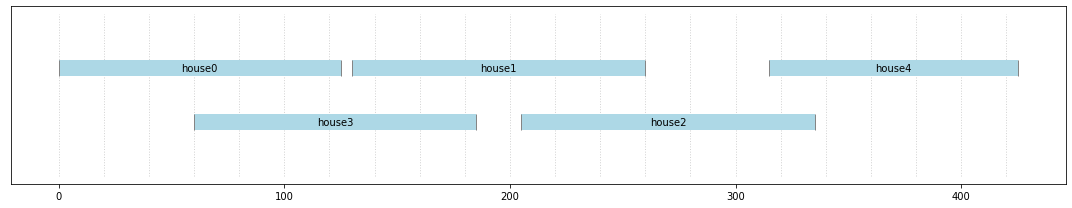

In [17]:
# 家単位の建築スケジュール

rcParams['figure.figsize'] = 15, 3

for h in Houses:
    hkey = 'house' + str(h)
    wt = msol2.get_var_solution(hkey)
    visu.interval(wt, 'lightblue', hkey)
visu.show()

In [18]:
visu = reload(visu)

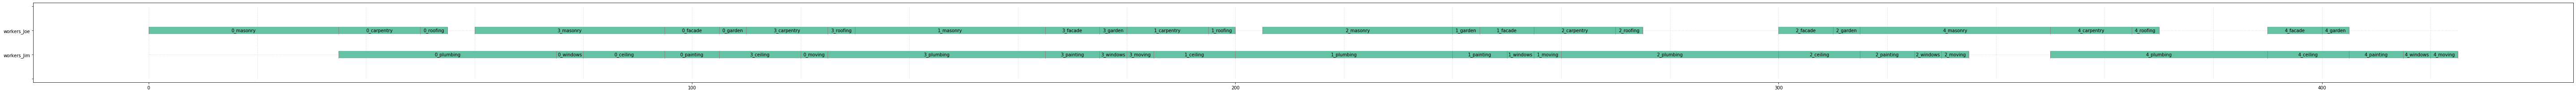

In [19]:
# 作業者単位の建築スケジュール
# ダブルクリックで拡大表示されます

rcParams['figure.figsize'] = 80, 3

for worker in WorkerNames:
    name = 'workers_' + worker
    seq = msol2.get_var_solution(name)
    visu.sequence(name=name, intervals=seq)
visu.show()